In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from open3d import geometry, visualization, io, utility
import laspy as lp 

import rasterio
import alphashape as ash 
import geopandas as gpd 
import shapely as sh 

from rasterio.transform import from_origin
from rasterio.enums import Resampling
from rasterio.features import shapes 
from shapely.geometry import Polygon

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Data collection and information.
[Link to Data](https://opendata.vancouver.ca/explore/dataset/lidar-2022/information/?location=12,49.25315,-123.10472)


In [2]:
las = lp.read("./neighborhood.laz")

In [3]:
print(np.unique(las.classification))
print([dim.name for dim in las.point_format.dimensions])

[1 2 3 5 6 7]
['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'synthetic', 'key_point', 'withheld', 'overlap', 'scanner_channel', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'user_data', 'scan_angle', 'point_source_id', 'gps_time', 'red', 'green', 'blue']


In [4]:
crs = las.vlrs[2].string
print(las.vlrs[2].string)

PROJCS["NAD_1983_UTM_Zone_10N",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-123.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0],AUTHORITY["EPSG",26910]]


In [5]:
pts_mask = las.classification == 6

xyz_t = np.vstack((las.x[pts_mask], las.y[pts_mask], las.z[pts_mask]))

pcd_03d = geometry.PointCloud()
pcd_03d.points = utility.Vector3dVector(xyz_t.transpose())

pcd_center = pcd_03d.get_center()
pcd_03d.translate(-pcd_center)

visualization.draw_geometries([pcd_03d])

In [6]:
pts_mask = las.classification == 2
xyz_t = np.vstack((las.x[pts_mask], las.y[pts_mask], las.z[pts_mask]))

ground_points = geometry.PointCloud()
ground_points.points = utility.Vector3dVector(xyz_t.transpose())

ground_points.translate(-pcd_center)

visualization.draw_geometries([ground_points])

In [7]:
nn_distance = np.mean(pcd_03d.compute_nearest_neighbor_distance())
print(nn_distance)

0.11673857611056317


## Single Unit Experiments
- Unsupervised Segmentation.
- 3D House Segmentation.
- 2D Building Footprint Extraction.
- Semantic and Attribute Extraction.
- 2D to 3D.
- 3D Model Creation (vertices).
- 3D Model Creation (meshes).
- Post-Processing and Export.

In [8]:
epsilon = 2
min_cluster_points = 100

labels = np.array(pcd_03d.cluster_dbscan(epsilon, min_cluster_points))
max_label = labels.max()
print(f"point cloud has {max_label+1} clusters.")

colors = plt.get_cmap("tab20")(labels/ (max_label if max_label > 0 else 1))
colors[labels< 0] = 0
pcd_03d.colors = utility.Vector3dVector(colors[:, :3])

visualization.draw_geometries([pcd_03d])

point cloud has 31 clusters.


In [9]:
sel = 1
segment = pcd_03d.select_by_index(np.where(labels == sel)[0])
visualization.draw_geometries([segment])

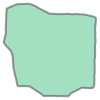

In [10]:
points_2D = np.asarray(segment.points)[:, 0:2]
building_vector = ash.alphashape(points_2D, alpha=.5)
building_vector

In [11]:
building_gdf = gpd.GeoDataFrame(geometry=[building_vector], crs="EPSG:26910")
building_gdf.head(1)

,geometry
0,"POLYGON ((-42.952 -15.990, -42.499 -16.049, -4..."


In [12]:
altitude = np.asarray(segment.points)[:,2]+pcd_center[2]
height_test = np.max(altitude)- np.min(altitude)
print("Is this correct: ", height_test)

query_point = segment.get_center()
query_point[2] = segment.get_min_bound()[2]
pcd_tree = geometry.KDTreeFlann(ground_points)
[k, idx, _] = pcd_tree.search_knn_vector_3d(query_point, 200)

sample = ground_points.select_by_index(idx, invert=False)
sample.paint_uniform_color([.5, .5, .5])
# visualization.draw_geometries([sample, ground_points])

ground_zero = sample.get_center()[2]

height = segment.get_max_bound()[2] - ground_zero

print("True Height", height)

Is this correct:  10.192000000000007
True Height 10.070570000000004


In [13]:
building_gdf[['id']] = sel 
building_gdf[['height']] = segment.get_max_bound()[2] - sample.get_center()[2]
building_gdf[['area']]  = building_vector.area 
building_gdf[['perimeter']] = building_vector.length
building_gdf[['local_cx', 'local_cy', 'local_cz']] = np.asarray([building_vector.centroid.x, building_vector.centroid.y, sample.get_center()[2]])
building_gdf[['transl_x', 'transl_y', 'transl_z']] = pcd_center
building_gdf[['pts_number']] = len(segment.points)

building_gdf.head(1)

,geometry,id,height,area,perimeter,local_cx,local_cy,local_cz,transl_x,transl_y,transl_z,pts_number
0,"POLYGON ((-42.952 -15.990, -42.499 -16.049, -4...",1,10.07057,217.271398,58.079869,-43.39485,-22.418669,-4.426159,490276.695828,5.453749e+06,109.171589,7747


The local minima (along the Z axis) -4.54758912976655
The local maxima (along the Z axis) 5.6444108702334574


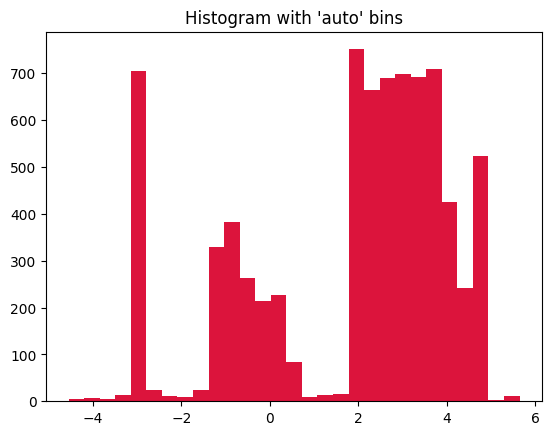

In [14]:
points_1D = np.asarray(segment.points)[:,2]
print('The local minima (along the Z axis)',np.min(points_1D))
print('The local maxima (along the Z axis)',np.max(points_1D))

plt.hist(points_1D, bins='auto', color='crimson')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [15]:
vertices = list(building_vector.exterior.coords)

polygon_2d = geometry.LineSet()
polygon_2d.points = utility.Vector3dVector([point + (0,) for point in vertices])
polygon_2d.lines = utility.Vector2iVector([(i, (i+1) % len(vertices)) for i in range(len(vertices))])

visualization.draw_geometries([polygon_2d])

In [16]:
extrusion = geometry.LineSet()
extrusion.points = utility.Vector3dVector([point + (height,) for point in vertices])
extrusion.lines = utility.Vector2iVector([(i, (i + 1) % len(vertices)) for i in range(len(vertices))])
visualization.draw_geometries([polygon_2d, extrusion])

#Plot the vertices
temp = polygon_2d + extrusion
temp.points
temp_o3d = geometry.PointCloud()
temp_o3d.points = temp.points
visualization.draw_geometries([temp_o3d])

In [17]:
a = np.array(building_vector.exterior.coords)
b = np.ones([a.shape[0],1])*sample.get_center()[2]
c = np.ones([a.shape[0],1])*(sample.get_center()[2] + height)

#Define the ground footprint and the height arrays of points
ground_pc = np.hstack((a, b))
up_pc = np.hstack((a, c))

#Generate an Open3D "point cloud" made of the major points
temp_o3d = geometry.PointCloud()
temp_o3d.points = utility.Vector3dVector(np.concatenate((ground_pc, up_pc), axis=0))
visualization.draw_geometries([temp_o3d])

In [18]:
alpha = 20
print(f"alpha={alpha:.3f}")
mesh = geometry.TriangleMesh.create_from_point_cloud_alpha_shape(temp_o3d, alpha)
mesh.compute_vertex_normals()
mesh.paint_uniform_color([0.5,0.4,0])
visualization.draw_geometries([temp_o3d, mesh, segment], mesh_show_back_face=True)

alpha=20.000
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra

In [19]:
mesh.translate(pcd_center)

#Export the Mesh
io.write_triangle_mesh('./house_sample.ply', mesh, write_ascii=False, compressed=True, write_vertex_normals=False, write_vertex_colors=False, write_triangle_uvs=False)

#Export the shapefile
building_gdf.to_file("./single_building.shp")

## Automation and Scaling.

In [21]:
import random
def random_color_generator():
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return [r/255, g/255, b/255]

#Initializing the GeodataFrame
buildings_gdf = gpd.GeoDataFrame(columns=['id', 'geometry', 'height', 'area', 'perimeter', 'local_cx', 'local_cy', 'local_cz', 'transl_x', 'transl_y', 'transl_z'], geometry='geometry', crs='EPSG:26910')

# Reducing the output wave of Open3D
utility.set_verbosity_level(utility.VerbosityLevel.Error)

#Creating the loop
for sel in range(max_label+1):
    #1. Select the Segment
    segment = pcd_03d.select_by_index(np.where(labels==sel)[0])
    # o3d.visualization.draw_geometries([segment])

    #2. Compute the building footprint
    # altitude = np.asarray(segment.points)[:,2]+pcd_center[2]
    points_2D = np.asarray(segment.points)[:,0:2]
    building_vector = ash.alphashape(points_2D, alpha=0.5)
    
    #3. Compute the height of the segment (house candidate).
    query_point = segment.get_center()
    query_point[2] = segment.get_min_bound()[2]
    pcd_tree = geometry.KDTreeFlann(ground_points)
    [k, idx, _] = pcd_tree.search_knn_vector_3d(query_point, 50)
    sample = ground_points.select_by_index(idx, invert=False)
    ground_zero = sample.get_center()[2]
    
    #4. Create the geopandas with attributes entry
    building_gdf = gpd.GeoDataFrame(geometry=[building_vector], crs='EPSG:26910')
    building_gdf[['id']] = sel
    building_gdf[['height']] = segment.get_max_bound()[2] - sample.get_center()[2]
    building_gdf[['area']] = building_vector.area
    building_gdf[['perimeter']] = building_vector.length
    building_gdf[['local_cx','local_cy','local_cz']] = np.asarray([building_vector.centroid.x, building_vector.centroid.y, sample.get_center()[2]])
    building_gdf[['transl_x','transl_y','transl_z']] = pcd_center
    building_gdf[['pts_number']] = len(segment.points)
    
    #4. Add it to geometries entries
    buildings_gdf = pd.concat([buildings_gdf, building_gdf])

#5. Compute the 3D Vertices Geometries
    a = np.array(building_vector.exterior.coords)
    b = np.ones([a.shape[0],1])*sample.get_center()[2]
    c = np.ones([a.shape[0],1])*(sample.get_center()[2] + height)
    ground_pc = np.hstack((a, b))
    up_pc = np.hstack((a, c))
    temp_o3d = geometry.PointCloud()
    temp_o3d.points = utility.Vector3dVector(np.concatenate((ground_pc, up_pc), axis=0))
    
    #5. Compute the 3D Geometry of a house 
    alpha = 20
    mesh = geometry.TriangleMesh.create_from_point_cloud_alpha_shape(temp_o3d, alpha)
    mesh.translate(pcd_center)
    mesh.paint_uniform_color(random_color_generator())    #5. Compute the 3D Vertices Geometries

    
    io.write_triangle_mesh('./house_'+str(sel)+'.ply', mesh, write_ascii=False, compressed=True, write_vertex_normals=False)

/tmp/ipykernel_62460/966049208.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  buildings_gdf = pd.concat([buildings_gdf, building_gdf])


In [22]:
buildings_gdf.head(5)

,id,geometry,height,area,perimeter,local_cx,local_cy,local_cz,transl_x,transl_y,transl_z,pts_number
0,0,"POLYGON ((-70.127 -28.661, -70.197 -28.530, -7...",8.22666,220.044376,58.509767,-65.353656,-21.865790,-4.354249,490276.695828,5.453749e+06,109.171589,7835.0
0,1,"POLYGON ((-42.952 -15.990, -42.499 -16.049, -4...",10.01868,217.271398,58.079869,-43.394850,-22.418669,-4.374269,490276.695828,5.453749e+06,109.171589,7747.0
0,2,"POLYGON ((-67.175 14.134, -67.244 13.334, -67....",3.77992,56.046655,28.919532,-70.892099,12.992831,-4.224509,490276.695828,5.453749e+06,109.171589,1850.0
0,3,"POLYGON ((-61.049 -6.239, -61.815 -6.460, -62....",3.43800,73.891078,33.293933,-59.835566,-2.574601,-4.319589,490276.695828,5.453749e+06,109.171589,2182.0
0,4,"POLYGON ((-62.549 -13.829, -62.043 -13.714, -6...",3.37544,19.282685,20.628842,-60.202507,-15.640869,-4.051029,490276.695828,5.453749e+06,109.171589,335.0


In [23]:
buildings_gdf.to_file("./neighborhood_buildings.shp")

## Visualization and Rasterization.

In [24]:
pixel_size = 1

x, y, z = xyz_t[0], xyz_t[1], xyz_t[2]

# Determine the extent of the DEM
min_x, max_x = np.min(x), np.max(x)
min_y, max_y = np.min(y), np.max(y)

# Calculate the number of pixels in X and Y directions
num_pixels_x = int((max_x - min_x) / pixel_size)
num_pixels_y = int((max_y - min_y) / pixel_size)

#profile the results
print("number of pixel along X and Y: ",num_pixels_x, num_pixels_y)

number of pixel along X and Y:  166 93


In [25]:
transform = from_origin(min_x, max_y, pixel_size, pixel_size)

# Create an array to store the elevation values
dem_array = np.zeros((num_pixels_y, num_pixels_x), dtype=np.float32)

In [26]:
col_indices = ((x - min_x) / pixel_size).astype(int)
row_indices = ((max_y - y) / pixel_size).astype(int)

# Mask to ensure indices are within bounds
valid_indices = (0 <= row_indices) & (row_indices < num_pixels_y) & (0 <= col_indices) & (col_indices < num_pixels_x)

# Populate the DEM array with elevation values from the point cloud
dem_array[row_indices[valid_indices], col_indices[valid_indices]] = z[valid_indices]

In [27]:
dem_array

array([[  0.   ,   0.   ,   0.   , ...,  99.073,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   , ...,  99.084,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   , ...,  99.089,   0.   ,   0.   ],
       ...,
       [  0.   ,   0.   ,   0.   , ..., 100.122, 100.109, 100.084],
       [  0.   ,   0.   ,   0.   , ..., 100.13 , 100.12 , 100.104],
       [  0.   ,   0.   ,   0.   , ..., 100.146, 100.136, 100.121]],
      dtype=float32)

In [28]:
with rasterio.open("./output_dem.tif", 'w', driver='GTiff', height=num_pixels_y, width=num_pixels_x,
                   count=1, dtype=np.float32, crs='EPSG:26910', transform=transform) as dst:
    dst.write(dem_array, 1)

In [ ]:
from rasterio.features import shapes
from shapely.geometry import Polygon
mask = None
with rasterio.Env():
 with rasterio.open("./output_dem.tif") as src:
     image = src.read(1) # first band
     results = (
     {'properties': {'raster_val': v}, 'geometry': s}
     for i, (s, v)
     in enumerate(
     shapes(image.astype(np.float32), mask=mask, transform=src.transform))
     )
 
 geoms = list(results)

In [ ]:
import geopandas as gpd
gdf = gpd.GeoDataFrame.from_features(geoms)